# Assignment 1
- **Assigned:** Friday, February 4
- **Due:** Friday, February 18 at 5pm

For the numerical computation in this assignment we will use Python with the [`numpy`](https://numpy.org/doc/stable/user/quickstart.html), [`scipy`](https://www.scipy.org/getting-started.html), [`matplotlib`](https://matplotlib.org/stable/tutorials/introductory/pyplot.html), and `pyomo` ([link](https://pyomo.readthedocs.io/en/stable/) and [link](https://jckantor.github.io/ND-Pyomo-Cookbook/)) packages. You may want to read their documentation to familiarize with them.

Remember that you need to submit to files to CANVAS: 
* This notebook, containing all the code you implemented
* A pdf with your answers to the questions

**Contents:**
 <pre>  [Problem 1](#p1)    [Problem 2](#p2)    [Problem 3](#p3)    [Problem 4](#p4)    [Problem 5](#p5)  </pre>

## Problem 1 <a name="p1"></a>

Let $f(u_1, u_2, u_3) = 3u_1^2 + 2u_1u_2 + 3u_2^2 + u_3^2 - 6u_1 + 14u_2 + u_3$.

1. Analytically find the stationary points for this function and check if they are a maximum, minimum, or saddle point.

2. Now assume that a constraint $c_1(u_1,u_2,u_3) = 2u_1 + 3u_2 + 4u_3 = 0$ is added, use Lagrange multiplier techniques to find the minimum.

3. If the constraint in (2) is replaced with $c_2(u_1,u_2,u_3) = 2(u_1-u_2)^2-4 = 0$, use Lagrange multiplier techniques to find the minimum.

## Problem 2

This problem explores the steepest descent algorithm on the optimization problem
$$
\min_x F(x_1,x_2,x_3) = x_1^2 + x_2^2 + x_3^2 - x_1x_2 - x_2x_3 - 2x_1 - 8x_3.
$$

1. Give an expression for the search direction $\mathbf{p}_k$ for the steepest descent method.
    
2. Using $\mathbf{x}_0=\begin{bmatrix}1&1&-1\end{bmatrix}^\top$, write out the first iteration of the steepest descent algorithm. What is $\mathbf{x}_1 = \mathbf{x}_0 + \alpha\mathbf{p}_0$ in terms of $\alpha_0$? What is the optimal value for $\alpha_0$ that minimizes $F(\mathbf{x}_0+\alpha_0\mathbf{p}_0)$?
    
3. Write Python code to solve this optimization problem using a steepest descent gradient search algorithm and an initial value of $\mathbf{x}_0=\begin{bmatrix}1&1&1\end{bmatrix}^\top$. Most of the bracketing method has already been implemented for you. This first part of this method generates an interval $[a,b]$ of possible values for $\alpha$ (the step size). Your task is, given this interval $[a,b]$, sample 10 possible $\alpha$ in that interval, and take the first $\alpha$ for which the Wolfe conditions are satisfied. For the Wolfe conditions, use $c_1=10^{-4}$ and $c_2=0.9$.  Starter Python code is given below.

> **Note**: Typically, the Wolfe conditions are used in combination with bisection or backtracking methods. In this problem, we simply use the bracketing method, and a simple option (which may work, depending on the specific problem) would be to take $\alpha$ as the midpoint in $[a,b]$. Here we ask you instead to try several $\alpha$ and pick the first $\alpha \in [a,b]$ for which the Wolfe conditions are satisfied.
    
  Iterate your algorithm until either (or both) $\left|\mathbf{x}_{k+1}-\mathbf{x}_k\right|\leq 10^{-9}$ and/or $\left|F(\mathbf{x}_{k+1})-F(\mathbf{x}_k)\right|\leq 10^{-9}$. How many iterations does it take for your algorithm to converge?
      
  Note the use of $g_a$ and $g_b$ in the discussion of a line search using $\mathbf{p}$ are in terms of "scalar directional derivatives", so that if $\mathbf{x}_{k+1}=\mathbf{x}_k + \alpha\mathbf{p}$, then
  $$
  g_a = \left.\frac{\partial F}{\partial\alpha}\right|_{\mathbf{x}_\alpha} = \left.\frac{\partial F}{\partial\mathbf{x}}\frac{\partial\mathbf{x}}{\partial\alpha}\right|_{\mathbf{x}_\alpha} = \left.\mathbf{g}^\top\mathbf{p}\right|_{\mathbf{x}_\alpha}.
  $$
    
4. Use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) with BFGS to solve for the minimum and compare its performance with your algorithm.

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
print(np.__version__)
def satisfies_wolfe_condit(F, x, p, g, α):
    """
    Check for satisfaction of Wolfe conditions 
    
    Parameters
    ----------
    F : function
        the function being minimized
    x : np.array
        the current iterate, i.e., current guess of minimum
    p : np.array
        search direction
    g : function
        the gradient of the function
    α : float
        step size to move in 
        
    Returns
    -------
    cond : bool
           whether or not the Wolfe conditions are satisfied
    """
    cond=False
    c1=0.0001
    c2=0.9
    if (F(x+α*p)<=F(x)+c1*α*np.dot(p,g(x))):
        if (-np.dot(p,g(x+α*p))<=-c2*np.dot(p,g(x))):
            cond=True
    return cond

def bracketing_line_search(F, x, p, g, Del=0.4):
    """
    Line search for determining step size via bracketing
    
    Parameters
    ----------
    F : function
        the function being minimized
    x : np.array
        the current iterate, i.e., current guess of minimum
    p : np.array
        search direction
    g : function
        the gradient of the function
    Del : float
        arbitrary interval size for bracket
        
    Returns
    -------
    α : float
        step size to move in   
    """
    MAX_BRACKET_ITERS = 100
    
    β = 1 # interval length
    a0 = 0 # starting point
    b0 = a0 + β*Del # ending of first bracket
    
    # Determine which direction to search

    Fa = F(x + a0*p)
    Fb = F(x + b0*p)
    if Fb > Fa:
        # search opposite direction
        Del = -Del

        # recalculate end of bracket and objective value
        # at the end of the first bracket
        b0 = a0 + Del
        Fb = F(x + b0*p)

    # Actual bracketing happens here
    a = a0
    b = b0
    for i in range(MAX_BRACKET_ITERS):
        β = β * 1.25 # make interval length larger

        # go to next bracket
        anext = b
        bnext = anext + β*Del

        # objective value at start and end of bracket
        Fa = F(x + anext*p)
        Fb = F(x + bnext*p)

        if Fb > Fa:
            b = bnext
            break
            
        # commit to next bracket
        a = anext
        b = bnext
    
    #Select α by sampling in the bracket found, and checking the Wolfe conditions
    α_chosen = 0.001
    
    #.....
            
    return α_chosen
    

def steepest_descent(x0, F, g):
    """
    Steepest descent via gradient search
    
    Parameters
    ----------
    x0 : np.array
        initial condition
    F : function
        objective function to minimize
    g : function
        gradient of objective function
        
    Returns
    -------
    x : np.array
        minimum
    obj : float
        objective value at minimum
    iters : int
        number of iterations required to converge
    """
    
    xnew = x0
    
    MAX_GRAD_ITERS = 10000
    TOL = 1e-6
    
    for i in range(MAX_GRAD_ITERS):
        x = xnew
        p=-g(x)
        α=bracketing_line_search(F, x, p, g, Del=0.4)
        if satisfies_wolfe_condit(F, x, p, g, α):
            break
        else:
            xnew=x+α*p
        
    return x, F(x), i

1.20.1


In [18]:
# define problem data
F = lambda x: x[0]**2 + x[1]**2 + x[2]**2 - x[0]*x[1] - x[1]*x[2] - 2*x[0] - 8*x[2]
g = lambda x: np.array([2*x[0] - x[1] - 2, 2*x[1] - x[0] - x[2], 2*x[2] - x[1] - 8])

# choose initial condition
x0 = np.ones((3,))

# custom gradient descent solver
xopt, obj, iters = steepest_descent(x0, F, g)
print(f"GD minimizer after {iters} iterations: {xopt}")

# BFGS solver (using scipy.optimize.minimize)
print(minimize(F,x0,method='BFGS').x)

GD minimizer after 9999 iterations: [3.49025546 4.98621913 6.49025545]
[3.49999383 4.99999395 6.49999778]


## Problem 3 <a name="p3"></a>

For the cost function $F = x^2 + y^2 - 18xy - 4x - 5y$

1. Show analytically how to minimize the cost subject to the constraints
  $$
  \begin{array}{ll}
  f_1: & y\leq-x^2+4 \\
  f_2: & y\geq-x-1
  \end{array}
  $$
    
2. How is the optimal cost affected if the constraint $f_1$ is changed to
  $$
  \begin{array}{ll}
  f_1: & y\leq-x^2+4.1
  \end{array}
  $$
  Estimate this difference and explain your answer.
    
3. Using [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), confirm numerically your results in parts (1) and (2).

4. Using the code from part (3), describe what happens to the value of the Lagrange multipliers when the objective is maximized as opposed to minimized. How many constraints are active?

In [55]:
F = lambda x: x[0]**2 + x[1]**2  - 18*x[0]*x[1] - 4*x[0] - 5*x[1]
x0 = np.zeros((2,))
cons = ({'type': 'ineq', 'fun': lambda x:  -(x[0]**2 - 4 + x[1]) },
        {'type': 'ineq', 'fun': lambda x: -(x[0] + x[1] + 1) })
print('BFGS minimization of the cost function results in the following x')
print(minimize(F,x0,method='BFGS',tol=1e-6,constraints=cons,options = {'disp':True}).x)
print('and the following value of the function evaluated at this point')
print(F(minimize(F,x0,method='BFGS',tol=1e-6,constraints=cons).x))
print()
print("general scipy.optimize.minimize results in the following optimal point")
print(minimize(F,x0,tol=1e-6,constraints=cons,options = {'disp':True}).x)
print('with the function evaluated at this point being equal to')
print(F(minimize(F,x0,tol=1e-6,constraints=cons).x))

BFGS minimization of the cost function results in the following x
         Current function value: -8329039.645051
         Iterations: 1
         Function evaluations: 348
         Gradient evaluations: 112
[646.08460569 807.60575771]
and the following value of the function evaluated at this point
-8329039.64505087

general scipy.optimize.minimize results in the following optimal point
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10414.522322529203
            Iterations: 15
            Function evaluations: 62
            Gradient evaluations: 15
[ -13.46951394 -177.42780558]
with the function evaluated at this point being equal to
-10414.522322529203


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


## Problem 4 <a name="p4"></a>

1. (Bryson & Ho) Analytically find the rectangle of maximum perimeter that can be inscribed in an ellipse; that is,

  $$
  \begin{aligned}
  & \underset{x,y\,\in\,\mathbb{R}}{\text{maximize}} &&  P(x,y) = 4(x + y)  \\
  & \text{subject to}  & &  \frac{x^2}{a^2} + \frac{y^2}{b^2} = 2 \\
  \end{aligned}
  $$


2. With parameters $a=2$, $b=3$ use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to solve for $x,y$.


3. With the same parameters use `pyomo` to solve this static optimization for $x,y$.


In [61]:
from matplotlib.patches import Rectangle

# You may use this function to visualize the result
def plot_rect_in_ellipse(a, b, r, x, y):
    """
    Plots a rectangle inscribed in an ellipse

    Parameters
    ----------
    a : float
      semi-major axis
    b : float
      semi-minor axis
    r : float
      axis scaling / 'radius' parameter
    x : float
      rectangle half width
    y : float
      rectangle half height
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    t = np.linspace(0, 2*np.pi, 100)
    ax.plot(r*a*np.cos(t), r*b*np.sin(t),'k--') # parametric ellipse eqn
    ax.add_patch(Rectangle((-x,-y), 2*x, 2*y, fill=False, ec='b', lw=2))
    ax.grid();
    ax.axis('equal')
    ax.set_title('Largest Rectangle Inscribed in Ellipse')
    ax.set_xlabel('x'); ax.set_ylabel('y');

Optimization terminated successfully    (Exit mode 0)
            Current function value: -14.422205111214055
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 5
[1.10940064 2.49615064]


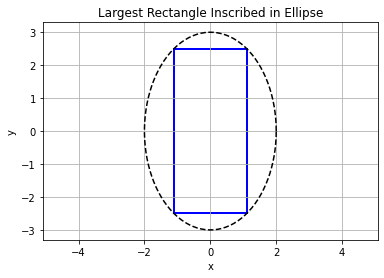

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
#Solve using scipy.optimize.minimize
F = lambda x: -4.0*(x[0]+x[1])
a=2;b=3
x0 = np.array([1.0, 2.5]).T

cons = ({'type': 'eq', 'fun': lambda x:  -((x[0]**2)/(a**2)+(x[1]**2)/(b**2)-1) })

res=minimize(F,x0,constraints=cons,bounds=((-2,2),(-3,3)),tol=1e-6,options = {'disp':True}).x
print(res)
plot_rect_in_ellipse(a, b, 1.0, res[0], res[1])


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 2
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0076253414154052734
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

model.x=1.5689290811518608
model.y=3.530090432440925


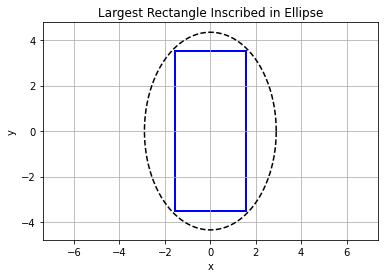

In [100]:
#import pyomo.environ as pe
from pyomo.environ import *
from pyomo.opt import SolverFactory
# Solve using pyomo
model=ConcreteModel()
model.x = Var( initialize=1.0, bounds=(-4, 4) )
model.y = Var( initialize=4.0, bounds=(-6, 6) )
model.obj = Objective(expr=-4*(model.x+model.y),sense=minimize)
model.limits = ConstraintList()
model.limits.add( (model.x**2)/(a**2)+(model.y**2)/(b**2) == 2)
opt = SolverFactory('ipopt')
results = opt.solve(model)
print(results)
print("model.x="+str(model.x.value))
print("model.y="+str(model.y.value))

plot_rect_in_ellipse(a, b, 1.45, model.x.value, model.y.value)

## Problem 5  <a name="p5"></a>
In this problem you will use Pyomo to optimize the 3D trajectory of a drone to go from a starting state to a goal state while minimizing a given cost. We will divide the trajectory into $S$ segments, each one of duration $dt$. Each dimension $\{x,y,z\}$ of each segment will be parametrized as a cubic polynomial. Hence, the resulting optimization problem will be a static optimization problem, where the decision varibles are the coefficients of these polynomials. 

> Although not required for this problem, if you are wondering why this parametrization makes sense for drones, you can read more about their differential flatness property [here](https://ieeexplore.ieee.org/document/5980409), and see some applications [here](https://youtu.be/jKmyW6v73tY?t=49)

![Alt text here](./traj_explanation.png)

Let $p$, $v$, $a$, $j$ denote, respectively, the position, velocity, acceleration, and jerk (remember that jerk is the derivative of the acceleration) of the drone. Each one of these variables is indexed by the segment $s$ and the dimension $d$ as $\cdot_{s,d}$ For example: 
* $p_{0,0}(\tau)$ is the position of the dimension $d=0$ (i.e., coordinate $x$) during the segment $s=0$ of the trajectory 
* $p_{0,2}(\tau)$ is the position of the dimension $d=2$ (i.e., coordinate $z$) during the segment $s=0$ of the trajectory  
* $a_{1,2}(\tau)$ is the acceleration of the dimension $d=2$ (i.e., coordinate $z$) during the segment $s=1$ of the trajectory 
* ...

Note that, as we are using cubic polynomials, $j_{s,d}(\tau)$ is constant for a given $d$ and $s$. We will also use the following definitions:
* $\tau$ is the time inside a segment ($\tau\in[0,dt]$)
* $t$ is the time along the trajectory ($t\in[0,Sdt]$)
* $\mathbb{S}:=\{0,1,...,S-1\}$, where $S$ is the number of segments of the trajectory.
* $\mathbb{D}:=\{0,1,2\}$. Note $\mathbb{D}$ is a set with 3 elements (corresponding to the dimensions \${x,y,z\}$)

* $\mathbb{C}:=\{0,1,2,3\}$. Note $\mathbb{C}$ is a set with 4 elements (corresponding to the four coefficients of a cubic polynomial)

* $\left\Vert \cdot \right\Vert_2 $ is the Euclidean norm, and $\left\Vert \cdot \right\Vert_2^2 $ is the Euclidean norm squared.


In this problem, we want to minimize the amount of jerk used by the drone (control cost) to go from a starting position, velocity, and acceleration, to a goal position, velocity and acceleration. We will use hard constraints for all the initial conditions, as well as for the final velocity and acceleration. The final position will be imposed as a soft constraint (i.e., a terminal cost in the cost function).

The optimization problem is therefore as follows:

  $$
  \begin{aligned}
  &\text{min}\;\; \underbrace{\left(\sum_{s\in\mathbb{S}}\left\Vert \left[\begin{array}{c}
j_{s,0}\\
j_{s,1}\\
j_{s,2}
\end{array}\right]\right\Vert _{2}^{2}dt\right)}_{\text{control cost}}+\omega\underbrace{\left\Vert \left[\begin{array}{c}
p_{S-1,0}(dt)\\
p_{S-1,1}(dt)\\
p_{S-1,2}(dt)
\end{array}\right]-\left[\begin{array}{c}
6\\
3\\
2
\end{array}\right]\right\Vert _{\;2}^{\;2}}_{\text{terminal cost}} \\
  &\text{subject to:}&   & &  \\
   &&&&\\
  %Initial conditions
  & \left.\begin{array}{c}
\left[\begin{array}{ccc}
p_{0,0}(0) & p_{0,1}(0) & p_{0,2}(0)\end{array}\right]^{T}=\left[\begin{array}{ccc}
0 & 0 & 0\end{array}\right]^{T}\\
\left[\begin{array}{ccc}
v_{0,0}(0) & v_{0,1}(0) & v_{0,2}(0)\end{array}\right]^{T}=\left[\begin{array}{ccc}
0 & 1 & 2\end{array}\right]^{T}\\
\left[\begin{array}{ccc}
a_{0,0}(0) & a_{0,1}(0) & a_{0,2}(0)\end{array}\right]^{T}=\left[\begin{array}{ccc}
0 & 0 & 1\end{array}\right]^{T}
\end{array}\right\} \text{initial conditions}&& \\
  &&&&\\
  %Final conditions
  & \left.\begin{array}{c}
\left[\begin{array}{ccc}
v_{S-1,0}(dt) & v_{S-1,1}(dt) & v_{S-1,2}(dt)\end{array}\right]^{T}=\left[\begin{array}{ccc}
0 & -1 & 0\end{array}\right]^{T}\\
\left[\begin{array}{ccc}
a_{S-1,0}(dt) & a_{S-1,1}(dt) & a_{S-1,2}(dt)\end{array}\right]^{T}=\left[\begin{array}{ccc}
1 & 0 & 0\end{array}\right]^{T}
\end{array}\right\} \text{final conditions}&& \\
  &&&&\\
  %Continuity
  & \left.\begin{array}{c}
p_{s,d}(dt)=p_{s+1,d}(0)\;\;\;\;\;\forall d\in\mathbb{D},\quad \forall s\in\mathbb{S} \setminus S-1\\
v_{s,d}(dt)=v_{s+1,d}(0)\;\;\;\;\;\forall d\in\mathbb{D},\quad \forall s\in\mathbb{S} \setminus S-1\\
a_{s,d}(dt)=a_{s+1,d}(0)\;\;\;\;\;\forall d\in\mathbb{D},\quad \forall s\in\mathbb{S} \setminus S-1
\end{array}\right\} \text{continuity between segments}&& \\
  \end{aligned}
  $$
  
where the decision variables are all the four coefficiens ($c\in\mathbb{C}$) of the polynomials of each dimension $d\in\mathbb{D}$ of each segment $s\in\mathbb{S}$. Note that $\omega$ is the terminal cost weight, and we will set it to $\omega=1000$ for this problem. We will also use $Sdt=5.0$ and $S=25$.

Please implement this problem using `pyomo`, solve it, plot the results, and print the control cost and terminal cost. Part of the needed code has already been done for you (see below).
**Hint**: A sanity check for your results is the following one: Given that we are using cubic polynomials for position, then: 
* Each coordinate of **Position** will be a continuous piecewise cubic function 
* Each coordinate of **Velocity** will be a continuous piecewise quadratic function  
* Each coordinate of **Acceleration** will be a continuous piecewise linear function  
* Each coordinate of **Jerk** will be piecewise constant function (and discontinuous)  


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 234
  Number of variables: 300
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.008503437042236328
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



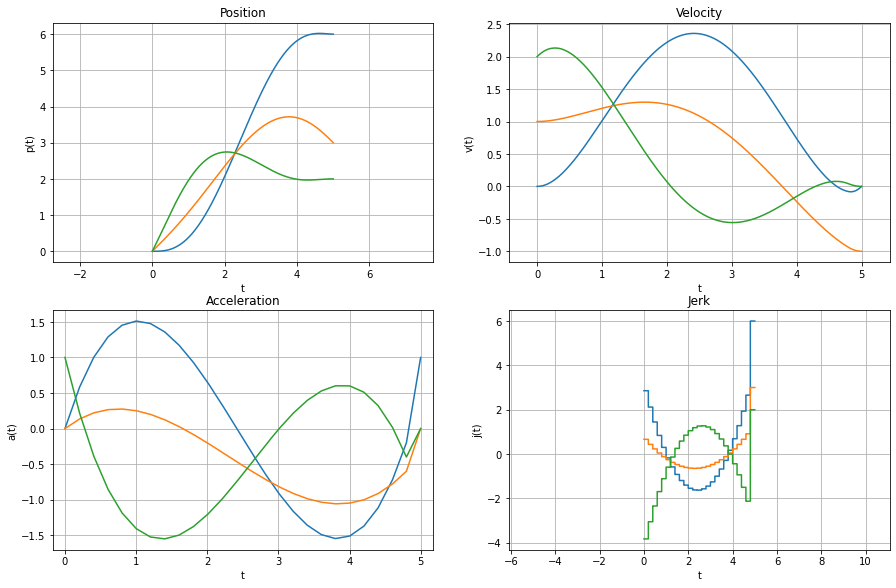

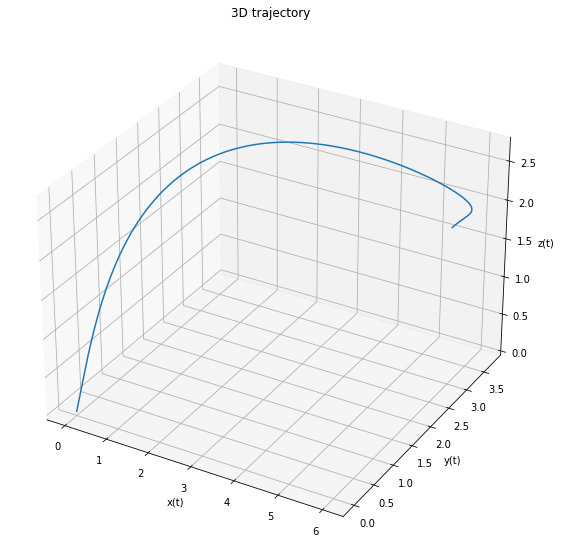

In [132]:
import pyomo.environ as pe
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

def getCoeff(seg, dim, coeff):
   return coeff[seg, dim, 0], coeff[seg, dim, 1], coeff[seg, dim, 2], coeff[seg, dim, 3]

def pos(seg, dim, coeff, τ):
   e,f,g,h=getCoeff(seg,dim,coeff)
   return e*(τ**3) + f*(τ**2) + g*(τ) +  h

def vel(seg, dim, coeff, τ):
   e,f,g,h=getCoeff(seg,dim,coeff)
   return 3*e*(τ**2) + 2*f*(τ) + g

def accel(seg, dim, coeff, τ):
   e,f,g,h=getCoeff(seg,dim,coeff)
   return 6*e*(τ) + 2*f

def jerk(seg, dim, coeff):
    e,f,g,h=getCoeff(seg,dim,coeff)
    return 6*e

S_dt=5.0; #Total time of the trajectory
S = 25 #Number of segments of the trajectory
dt=S_dt/S; #Total time spent per segment
omega=1000.0
init_pos=[0,0,0]
init_vel=[0,1,2]
init_accel=[0,0,1]

final_pos=  [6,3,2]
final_vel=  [0,-1,0]
final_accel=[1,0,0]

verbose=False

m = pe.ConcreteModel()
m.D_set = pe.RangeSet(0,2)       #Set that contains the indexes of the three Dimensions (x, y, z)
m.S_set = pe.RangeSet(0,S-1)     #Set that contains the indexes of the Segments of the trajectory
m.C_set = pe.RangeSet(0,3)       #Set that contains the indexes of the four Coefficients (e,f,g,h) of the cubic polynomial eτ^3 + fτ^2 + gτ+ h 

#Variables
m.coeff=pe.Var(m.S_set, m.D_set, m.C_set)

#Initial constraints
m.init_pos = pe.Constraint(m.D_set, rule = lambda m, dim: pos(0, dim, m.coeff, 0.0) == init_pos[dim])
m.init_vel=pe.Constraint(m.D_set, rule = lambda m, dim: vel(0, dim, m.coeff, 0.0) == init_vel[dim])
m.init_accel=pe.Constraint(m.D_set, rule = lambda m, dim: accel(0, dim, m.coeff, 0.0) == init_accel[dim])

#Final constraints
m.final_pos = pe.Constraint(m.D_set, rule = lambda m, dim: pos(S-1, dim, m.coeff, dt) == final_pos[dim])
m.final_vel=pe.Constraint(m.D_set, rule = lambda m, dim: vel(S-1, dim, m.coeff, dt) == final_vel[dim])
m.final_accel=pe.Constraint(m.D_set, rule = lambda m, dim: accel(S-1, dim, m.coeff, dt) == final_accel[dim])

#Continuity constraints.
m.continuity=ConstraintList()
for dim in m.D_set:
    for s in pe.RangeSet(0,S-2):
        m.continuity.add(pos(s,dim,m.coeff,dt)==pos(s+1,dim,m.coeff,0))
        m.continuity.add(vel(s,dim,m.coeff,dt)==vel(s+1,dim,m.coeff,0))
        m.continuity.add(accel(s,dim,m.coeff,dt)==accel(s+1,dim,m.coeff,0))
#Cost function
def ObjRule(m):
    return dt*sum(jerk(s,dim,m.coeff)**2 for dim in m.D_set for s in m.S_set) + omega*((jerk(S-1,0,m.coeff)-6)**2+(jerk(S-1,1,m.coeff)-3)**2+(jerk(S-1,2,m.coeff)-2)**2)

m.obj= pe.Objective(rule=ObjRule)

#Solve problem
opt = SolverFactory('ipopt')
results = opt.solve(m)


#Print control and terminal costs
print(results)

#Plots
all_τ=np.linspace(0, dt, 100)

all_pos=np.empty((3,0))
all_vel=np.empty((3,0))
all_accel=np.empty((3,0))
all_jerk=np.empty((3,0))
all_t=np.array([])

for seg in list(m.S_set):
    for τ in all_τ.tolist():
        pos_τ=np.array([[pos(seg,0,m.coeff,τ)()],[pos(seg,1,m.coeff,τ)()],[pos(seg,2,m.coeff,τ)()]]);
        vel_τ=np.array([[vel(seg,0,m.coeff,τ)()],[vel(seg,1,m.coeff,τ)()],[vel(seg,2,m.coeff,τ)()]]);
        accel_τ=np.array([[accel(seg,0,m.coeff,τ)()],[accel(seg,1,m.coeff,τ)()],[accel(seg,2,m.coeff,τ)()]]);
        jerk_τ=np.array([[jerk(seg,0,m.coeff)()],[jerk(seg,1,m.coeff)()],[jerk(seg,2,m.coeff)()]]);
    
        all_pos=np.concatenate((all_pos, pos_τ), axis=1)
        all_vel=np.concatenate((all_vel, vel_τ), axis=1)
        all_accel=np.concatenate((all_accel, accel_τ), axis=1)
        all_jerk=np.concatenate((all_jerk, jerk_τ), axis=1)
        
    all_t = np.concatenate((all_t, dt*seg + all_τ), axis=0)

def arrangePlot(title, y_label):
    ax.grid(); ax.axis('equal'); ax.set_title(title); ax.set_xlabel('t'); ax.set_ylabel(y_label);

fig, axes = plt.subplots(2,2,figsize=(15, 9.7))
#Plot position
ax=axes[0,0]; arrangePlot('Position', 'p(t)')
for dim in list(m.D_set):   ax.plot(all_t, all_pos[dim,:])

#Plot velocity
ax=axes[0,1]; arrangePlot('Velocity', 'v(t)')
for dim in list(m.D_set):   ax.plot(all_t, all_vel[dim,:])

#Plot accel
ax=axes[1,0]; arrangePlot('Acceleration', 'a(t)')
for dim in list(m.D_set):    ax.plot(all_t, all_accel[dim,:])

#Plot jerk
ax=axes[1,1]; arrangePlot('Jerk', 'j(t)')
for dim in list(m.D_set):    ax.plot(all_t, all_jerk[dim,:])

#Plot trajectory in 3D
fig = plt.figure(figsize=(15, 9.7))
ax = plt.axes(projection='3d')
ax.plot3D(all_pos[0,:], all_pos[1,:], all_pos[2,:])
ax.set_xlabel('x(t)'); ax.set_ylabel('y(t)'); ax.set_zlabel('z(t)');ax.set_title('3D trajectory');